In [68]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
import time 

In [69]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [80]:
device = torch.device('cpu')

## MLP on MINST

In [81]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [82]:
mnist_train = mnist_trainset.data
mnist_test = mnist_testset.data

mnist_trainlabel = mnist_trainset.targets
mnist_testlabel = mnist_testset.targets

mnist_train = mnist_train.to(device)
mnist_test = mnist_test.to(device)
mnist_trainlabel = mnist_trainlabel.to(device)
mnist_testlabel = mnist_testlabel.to(device)

In [83]:
print(mnist_train.shape)
print(mnist_test.shape)
print(mnist_trainlabel.shape)
print(mnist_testlabel.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [84]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 10) 


    def forward(self, x):
        x = x.view(-1,784) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [85]:
def accuracy(y_pred,y_ground):
    return (torch.sum(torch.argmax(y_pred,axis=1) == y_ground) / y_ground.size(0)).item()

In [86]:
def train(model, train_input, train_target, test_input, test_target, mini_batch_size, nb_epochs = 100, eta = 1e-3, verbose=False, milestones=[101,101]):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), eta, momentum=0)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1, verbose=False)
    
    history = {}
    history['loss'] = []
    history['loss_val'] = []
    history['acc'] = []
    history['acc_val'] = []
    
    for e in range(nb_epochs):
        total_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b , min(mini_batch_size, train_input.size(0)-b)))
            loss = criterion(output, train_target.narrow(0, b, min(mini_batch_size, train_input.size(0)-b)))
            total_loss = total_loss + loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        output_train = model(train_input.float())
        output_val = model(test_input.float())
            
        accuracy_train = accuracy(output_train, train_target)
        accuracy_val = accuracy(output_val, test_target)
        loss_train = criterion(output_train, train_target).item()
        loss_val = criterion(output_val, test_target).item()
            
        history['loss'].append(loss_train)
        history['loss_val'].append(loss_val)
        history['acc'].append(accuracy_train)
        history['acc_val'].append(accuracy_val)
        if verbose:
            print('Epoch %d/%d, Cross Entropy Loss: %.3f' %(e+1, nb_epochs, total_loss))
    
    return history
        

In [87]:
import time
import matplotlib.pyplot as plt

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-2,1e-3, 5e-3, 1e-4]
batch_sizes = [50,64,128]

mesh = np.meshgrid(batch_sizes, gammas)

for bs,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('batch-size: {} | learning-rate: {}'.format(bs,lr))
    # reset weights
    mlp = MLP().to(device)

    history = train(mlp, mnist_train.float(), mnist_trainlabel,
                mnist_test.float(), mnist_testlabel,
                mini_batch_size=bs,nb_epochs = 100,eta=lr,verbose=False)
    
    histories.append(history)

batch-size: 50 | learning-rate: 0.01
batch-size: 64 | learning-rate: 0.01
batch-size: 128 | learning-rate: 0.01
batch-size: 50 | learning-rate: 0.001
batch-size: 64 | learning-rate: 0.001
batch-size: 128 | learning-rate: 0.001
batch-size: 50 | learning-rate: 0.005
batch-size: 64 | learning-rate: 0.005
batch-size: 128 | learning-rate: 0.005
batch-size: 50 | learning-rate: 0.0001
batch-size: 64 | learning-rate: 0.0001
batch-size: 128 | learning-rate: 0.0001


In [ ]:
#Plot every epoch

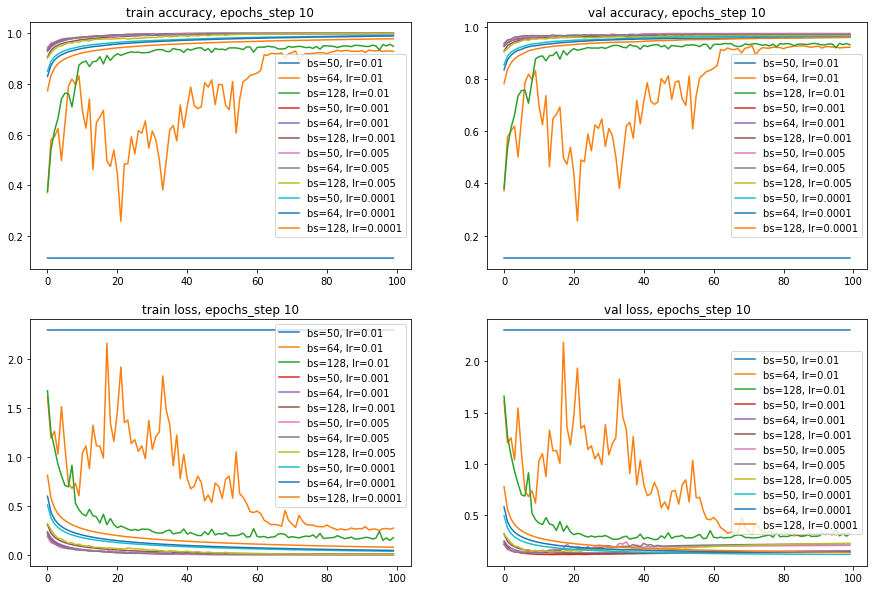

In [88]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
for j,(bs,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([i for i in range(100)],histories[j]['acc'],label='bs={}, lr={}'.format(bs,lr))
  ax[0,1].plot([i for i in range(100)],histories[j]['acc_val'],label='bs={}, lr={}'.format(bs,lr))

  ax[1,0].plot([i for i in range(100)],histories[j]['loss'],label='bs={}, lr={}'.format(bs,lr))
  ax[1,1].plot([i for i in range(100)],histories[j]['loss_val'],label='bs={}, lr={}'.format(bs,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

In [ ]:
# Plot every 10 epoch

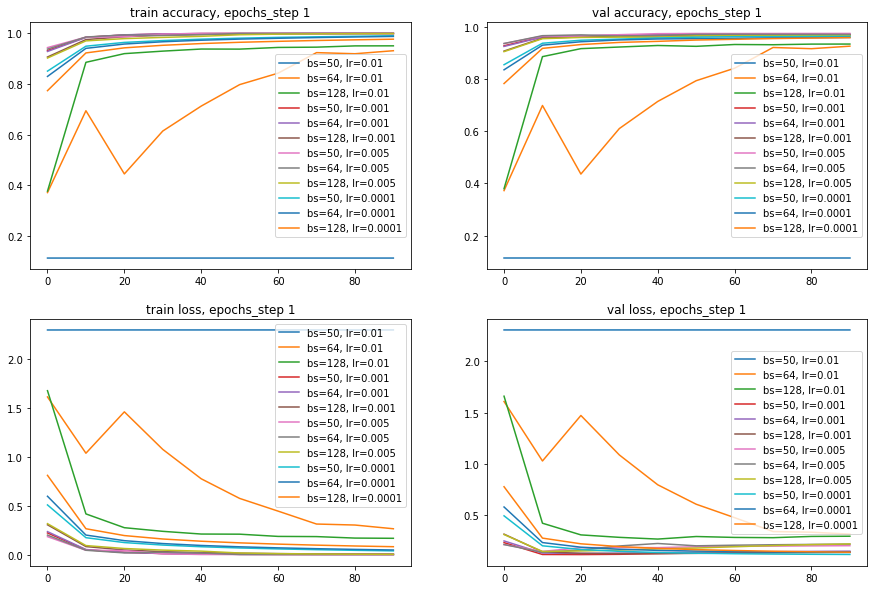

In [111]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
for j,(bs,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([10*i for i in range(10)],histories[j]['acc'][::10],label='bs={}, lr={}'.format(bs,lr))
  ax[0,1].plot([10*i for i in range(10)],histories[j]['acc_val'][::10],label='bs={}, lr={}'.format(bs,lr))

  ax[1,0].plot([10*i for i in range(10)],histories[j]['loss'][::10],label='bs={}, lr={}'.format(bs,lr))
  ax[1,1].plot([10*i for i in range(10)],histories[j]['loss_val'][::10],label='bs={}, lr={}'.format(bs,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

## CNN on CIFAR-10

In [98]:
device = torch.device('cuda')

In [99]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [100]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [101]:
def reverse_channel(img):
    # (X,X,3) -> (3,X,X)
    return np.stack((img[:,:,0],img[:,:,1],img[:,:,2]))

In [102]:
import numpy as np
# do not run often
cifar10_train = torch.tensor([reverse_channel(img) for img in trainset.data])
cifar10_test = torch.tensor([reverse_channel(img) for img in testset.data])

In [103]:
cifar10_trainlab = torch.tensor(trainset.targets)
cifar10_testlab = torch.tensor(testset.targets)

In [104]:
cifar10_train = cifar10_train.to(device)
cifar10_test = cifar10_test.to(device)
cifar10_trainlab = cifar10_trainlab.to(device)
cifar10_testlab = cifar10_testlab.to(device)

In [107]:
import time
import matplotlib.pyplot as plt

torch.manual_seed(123456789) # seeding for weight initialization and train

histories_cnn = []

gammas = [1e-2,1e-3, 5e-3, 1e-4]
batch_sizes = [50,64,128]

mesh = np.meshgrid(batch_sizes, gammas)

for bs,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('batch-size: {} | learning-rate: {}'.format(bs,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, cifar10_train.float(), cifar10_trainlab,
                cifar10_test.float(), cifar10_testlab,
                mini_batch_size=bs,nb_epochs = 100,eta=lr,verbose=False)
    
    histories_cnn.append(history)

batch-size: 50 | learning-rate: 0.01
batch-size: 64 | learning-rate: 0.01
batch-size: 128 | learning-rate: 0.01
batch-size: 50 | learning-rate: 0.001
batch-size: 64 | learning-rate: 0.001
batch-size: 128 | learning-rate: 0.001
batch-size: 50 | learning-rate: 0.005
batch-size: 64 | learning-rate: 0.005
batch-size: 128 | learning-rate: 0.005
batch-size: 50 | learning-rate: 0.0001
batch-size: 64 | learning-rate: 0.0001
batch-size: 128 | learning-rate: 0.0001


In [ ]:
# Plot every epoch

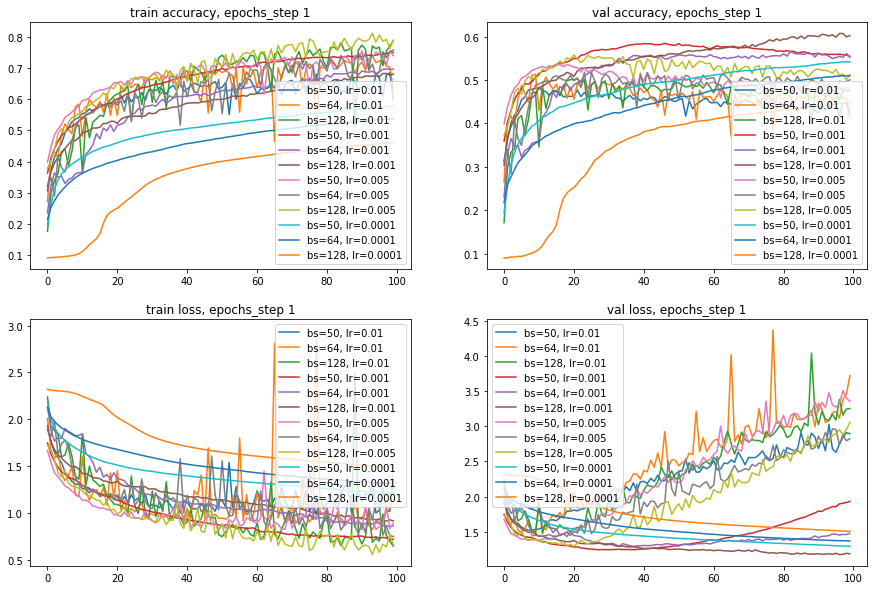

In [108]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
for j,(bs,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([i for i in range(100)],histories_cnn[j]['acc'],label='bs={}, lr={}'.format(bs,lr))
  ax[0,1].plot([i for i in range(100)],histories_cnn[j]['acc_val'],label='bs={}, lr={}'.format(bs,lr))

  ax[1,0].plot([i for i in range(100)],histories_cnn[j]['loss'],label='bs={}, lr={}'.format(bs,lr))
  ax[1,1].plot([i for i in range(100)],histories_cnn[j]['loss_val'],label='bs={}, lr={}'.format(bs,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

In [ ]:
# Plot every 10 epoch

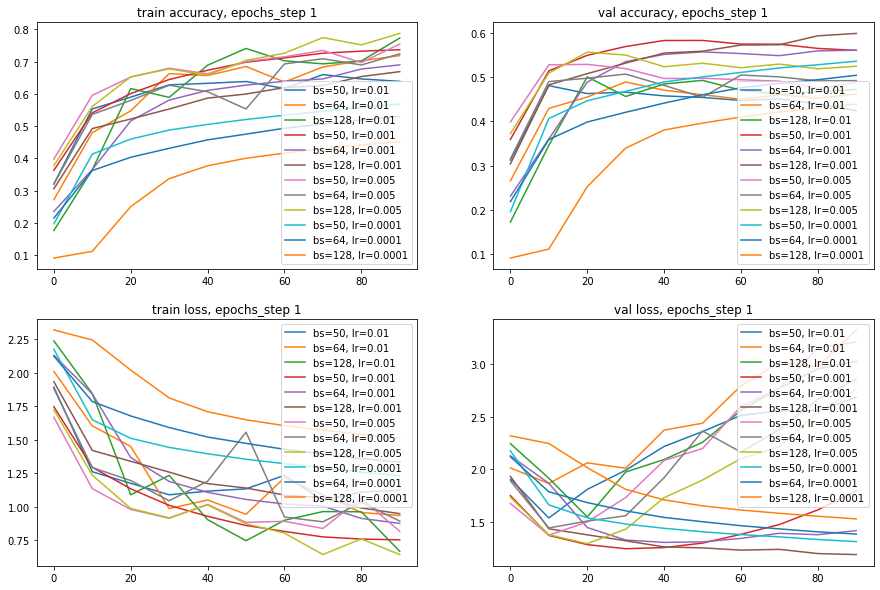

In [112]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
for j,(bs,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([10*i for i in range(10)],histories_cnn[j]['acc'][::10],label='bs={}, lr={}'.format(bs,lr))
  ax[0,1].plot([10*i for i in range(10)],histories_cnn[j]['acc_val'][::10],label='bs={}, lr={}'.format(bs,lr))

  ax[1,0].plot([10*i for i in range(10)],histories_cnn[j]['loss'][::10],label='bs={}, lr={}'.format(bs,lr))
  ax[1,1].plot([10*i for i in range(10)],histories_cnn[j]['loss_val'][::10],label='bs={}, lr={}'.format(bs,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()